In [104]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
path = './input/'
filename1 = path + '03_Const_Bathymetry_3000m.txt'
#filename1 = path + '02_Shot1.txt'
filename2 = path + '03_Const_Bathymetry_3000m.txt'
#filename2 = path + '02_Shot1.txt'

In [3]:
minval = 120
maxval = 180
depth = 20
grid_spac = 500.0

In [4]:
f = open(filename1)
lines = f.read().splitlines()
f.close()
for i, line in enumerate(lines):
    if i < 30:
        print(i, line)

0 FileType : Sound Exposure Level
1 FileVersion : 5
2 SourceKernel : 2.0
3 Routine : Parabolic
4 SEL_window_length(ms) : 10500
5 Azimuth_beg : 0
6 Azimuth_end : 350
7 Azimuth_inc : 10
8 Range_beg : 100
9 Range_end : 60000
10 Range_inc : 100
11 Depth_beg : 20
12 Depth_end : 40
13 Depth_inc : 20
14 Filter_bool : 0
15 Coordinate_system : Cylindrical
16 Sea_WaterAttn : None
17 Notional_name : 4135H__080_2100_080
18 
19 Azimuth:deg  Range:m  Depth:m  SEL:dB re 1uPa^2 s  
20 0            100      20       182.575             
21 0            100      40       184.147             
22 0            200      20       173.75              
23 0            200      40       176.159             
24 0            300      20       168.177             
25 0            300      40       170.757             
26 0            400      20       164.074             
27 0            400      40       166.636             
28 0            500      20       160.935             
29 0            500      40       

In [5]:
column_names = ['Azimuth', 'Range', 'Depth', 'SEL']

In [6]:
shot1 = pd.DataFrame()
shot2 = pd.DataFrame()

In [7]:
shot1 = pd.read_csv(filename1, names=column_names, skiprows=20, delim_whitespace=True)
shot2 = pd.read_csv(filename2, names=column_names, skiprows=20, delim_whitespace=True)

In [8]:
len(shot2)

43200

In [9]:
shot1 = shot1.loc[(shot1['Depth'] == depth)].reset_index(drop=True)
shot2 = shot2.loc[(shot2['Depth'] == depth)].reset_index(drop=True)

In [10]:
shot1.drop(['Depth'], axis=1, inplace=True)
shot2.drop(['Depth'], axis=1, inplace=True)

In [11]:
#shot

In [12]:
shot1_pivot = shot1.pivot(index='Azimuth', columns='Range', values='SEL')
shot2_pivot = shot2.pivot(index='Azimuth', columns='Range', values='SEL')

In [13]:
shot1_pivot.max().max()

183.86599999999999

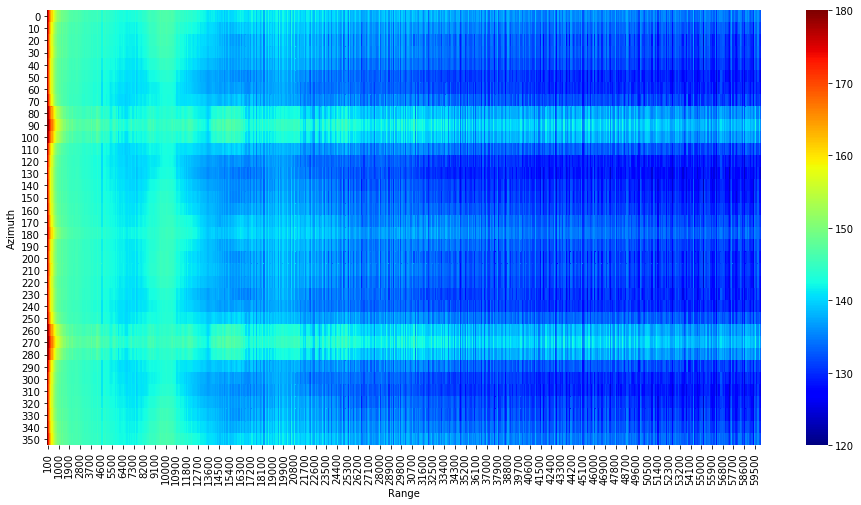

In [14]:
plt.figure(figsize=(16,8))
#plt.title(plottitle)
sns.heatmap(shot1_pivot, cmap='jet', vmin=minval, vmax=maxval);

In [15]:
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import interp1d


In [16]:
'''def extrapolate_range(data_azm_range):
    dist = pd.to_numeric(data_azm_range.columns)
    azm = pd.to_numeric(data_azm_range.index)
    z = data_azm_range.values
    X_max = 100000.0
    x_extrapol = np.arange(dist.min(), X_max + 100.0, 100.0)
    x = np.arange(dist.min(), dist.max() + 100.0, 100.0)
    #print(x)
    #print(azm)
    #print(z[0])
    f = interp1d(x, z[0], kind='zero',fill_value='extrapolate', )
    z_extrapol = f(x_extrapol)
    #print(z_extrapol)
    #data_azm_range_extrapol = interp2d(x, azm, z)
    return z[0], z_extrapol
    #return pd.DataFrame(data_azm_range_extrapol, index=azm, columns=x)
   ''' 

"def extrapolate_range(data_azm_range):\n    dist = pd.to_numeric(data_azm_range.columns)\n    azm = pd.to_numeric(data_azm_range.index)\n    z = data_azm_range.values\n    X_max = 100000.0\n    x_extrapol = np.arange(dist.min(), X_max + 100.0, 100.0)\n    x = np.arange(dist.min(), dist.max() + 100.0, 100.0)\n    #print(x)\n    #print(azm)\n    #print(z[0])\n    f = interp1d(x, z[0], kind='zero',fill_value='extrapolate', )\n    z_extrapol = f(x_extrapol)\n    #print(z_extrapol)\n    #data_azm_range_extrapol = interp2d(x, azm, z)\n    return z[0], z_extrapol\n    #return pd.DataFrame(data_azm_range_extrapol, index=azm, columns=x)\n   "

In [17]:
#z, z_extrapol = extrapolate_range(shot1_pivot)

In [18]:
def add_azimuths(data_azm, azm_inc):
    x = pd.to_numeric(data_azm.columns)
    azm = pd.to_numeric(data_azm.index)
    z = data_azm.values
    y = np.arange(azm.min(), azm.max() + azm_inc + azm_inc, azm_inc)
    #print(x)
    z_extrapolate = []
    for i in range(len(x)):
        f = interp1d(azm, z[:,i], kind='linear', fill_value='extrapolate')
        #print(i)
        z_extrapolate.append(f(y))
    #print(len(z_extrapolate))
    #print(len(y))
    #print(len(x))
    return pd.DataFrame(np.transpose(z_extrapolate), index=y, columns=x)
    

In [19]:
shot1_interp = add_azimuths(shot1_pivot, 2)
shot2_interp = add_azimuths(shot2_pivot, 2)

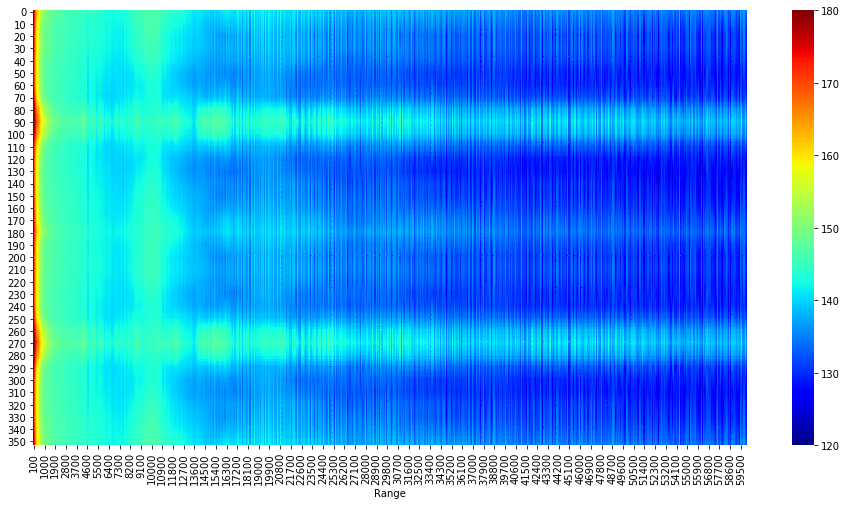

In [20]:
plt.figure(figsize=(16,8))
#plt.title(plottitle)
sns.heatmap(shot1_interp, cmap='jet', vmin=minval, vmax=maxval);

In [21]:
def map_to_cartesian(shot_pivot, rotation, grid_spacing):
    r = pd.to_numeric(shot_pivot.columns)
    theta = np.deg2rad(shot_pivot.index + rotation)# + np.deg2rad(rotation)
    rad_c, theta_c = np.meshgrid(r, theta)
    X = rad_c*np.cos(theta_c)
    Y = rad_c*np.sin(theta_c)
    X_max = 100000.0
    X_min = -100000.0
    Y_max = 100000.0
    Y_min = -100000.0
    #grid_spacing = 100.0   # You can change this
    nx = (X.max() - X.min())/grid_spacing
    ny = (Y.max() - Y.min())/grid_spacing
    x = np.arange(X.min(), X.max() + grid_spacing, grid_spacing)
    y = np.arange(Y.min(), Y.max() + grid_spacing, grid_spacing)
    #x = np.arange(X_min, X_max + grid_spacing, grid_spacing)
    #y = np.arange(Y_min, Y_max + grid_spacing, grid_spacing)
    grid_x, grid_y = np.meshgrid(x, y)
    new_grid = griddata(
        (X.flatten(), Y.flatten()),
        shot_pivot.values.flatten(),
        (grid_x, grid_y),
        method='linear'
    )
    #new_grid_extrapol = RectBivariateSpline(x, y, new_grid)
    return pd.DataFrame(new_grid, index=y, columns=x)
    

In [22]:
shot1_cartesian = map_to_cartesian(shot1_interp, 90, grid_spac)
shot2_cartesian = map_to_cartesian(shot2_interp, 54, grid_spac)

In [23]:
#shot1_cartesian[0]

In [125]:
jet = plt.get_cmap('jet', 12)
newcolors = jet(np.linspace(0, 1, 12))
white = np.array([256/256, 256/256, 256/256, 1])
newcolors[:2, :] = white
newcmp = ListedColormap(newcolors)

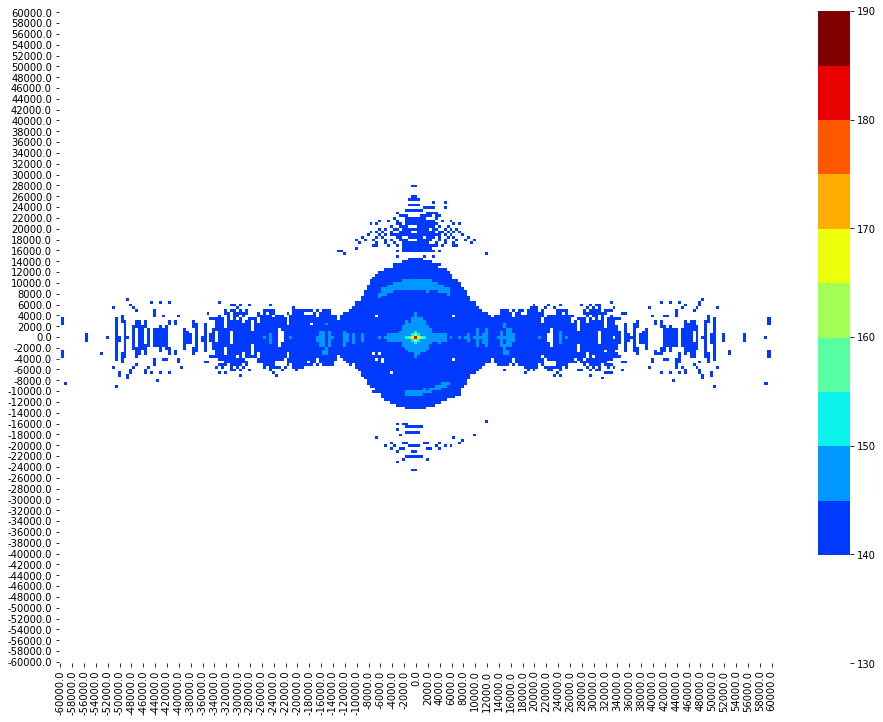

In [126]:
plt.figure(figsize=(16,12))
#plt.title(plottitle)
#cmap = plt.get_cmap('jet', 8)
#cmap.set_under('white')
ax = sns.heatmap(shot1_cartesian, cmap=newcmp, vmin=130, vmax=190)
ax.invert_yaxis()
plt.savefig('fig1.png');

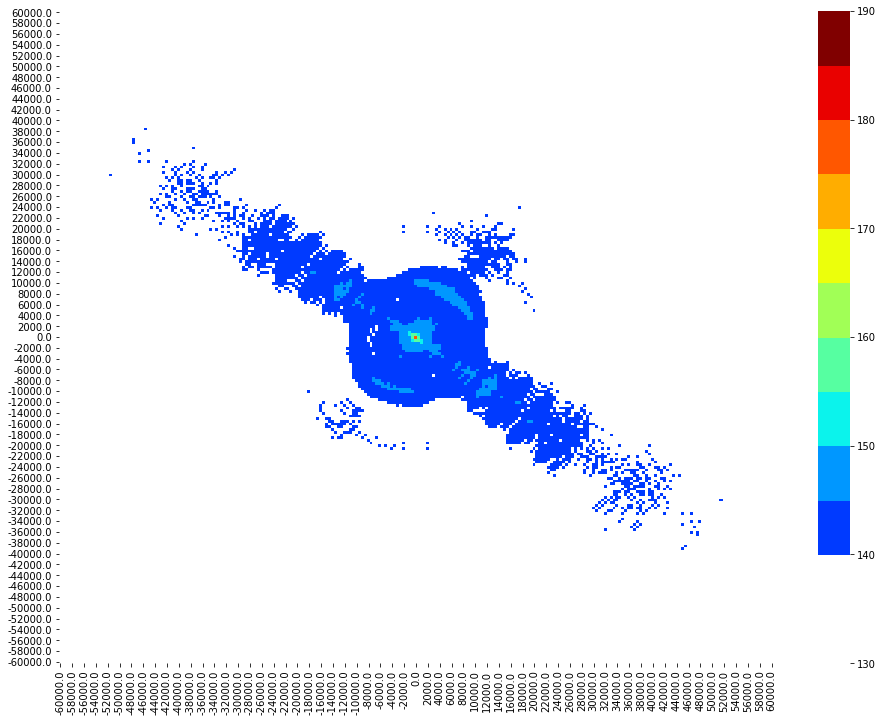

In [127]:
plt.figure(figsize=(16,12))
#plt.title(plottitle)
cmap = plt.get_cmap('jet', 8)
cmap.set_under('white')
ax = sns.heatmap(shot2_cartesian, cmap=newcmp, vmin=130, vmax=190)
ax.invert_yaxis()
plt.savefig('fig2.png');

In [26]:
def dB_sum(amp1, amp2):
    x = amp1/10
    y = amp2/10
    amp_comb = 10*np.log10(10**x + 10**y)
    return amp_comb 

In [27]:
#utm_xmin = 200000
utm_xmin = 167000
utm_xmax = 600000
#utm_ymin = 7090000
utm_ymin = 7060000
utm_ymax = 7690000
utm_x = np.arange(utm_xmin, utm_xmax + grid_spac, grid_spac)
utm_y = np.arange(utm_ymin, utm_ymax + grid_spac, grid_spac)
#utm_grid_x, utm_grid_y = np.meshgrid(utm_x, utm_y)

        

In [28]:
background_grid = np.full((len(utm_y), len(utm_x)), 120)

In [29]:
background = pd.DataFrame(background_grid, index=utm_y, columns=utm_x)

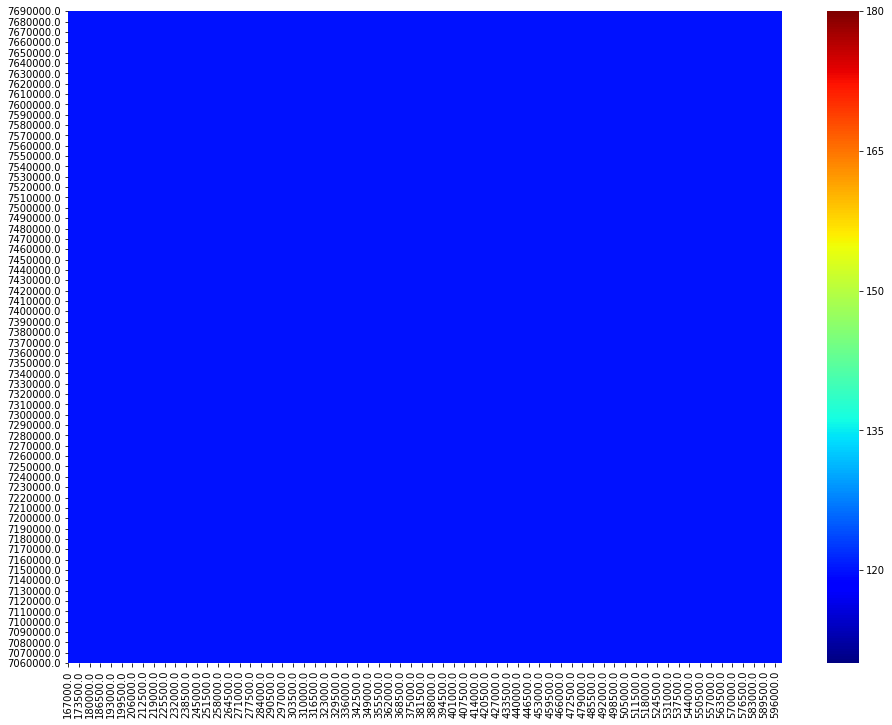

In [30]:
plt.figure(figsize=(16,12))
#plt.title(plottitle)
ax = sns.heatmap(background, cmap='jet', vmin=110, vmax=maxval)
ax.invert_yaxis();

In [31]:
def shift_shot(shot, utm_x, utm_y):
    x = pd.to_numeric(shot.columns)
    y = pd.to_numeric(shot.index)
    shift_x = -x + utm_x
    shift_y = -y + utm_y
    #print(shift_x)
    return pd.DataFrame(shot.values, index=shift_y, columns=shift_x)

In [32]:
shot1_DW = shift_shot(shot1_cartesian, 428000, 7430000)
shot2_DW = shift_shot(shot1_cartesian, 434000, 7579000)
shot3_DW = shift_shot(shot1_cartesian, 533500, 7580000)
shot4_DW = shift_shot(shot1_cartesian, 534000, 7430500)

In [33]:
shot1_CF = shift_shot(shot2_cartesian, 332000, 7342500)
shot2_CF = shift_shot(shot2_cartesian, 405000, 7291000)
shot2b_CF = shift_shot(shot2_cartesian, 406000, 7228500)
shot3_CF = shift_shot(shot2_cartesian, 329000, 7120000)
shot4_CF = shift_shot(shot2_cartesian, 227500, 7192500)


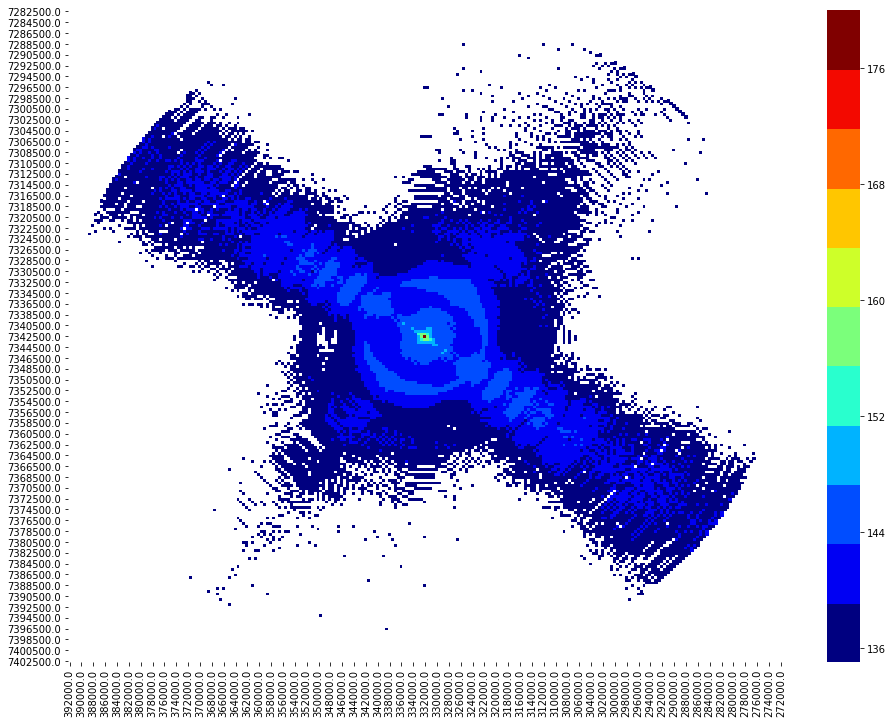

In [83]:
plt.figure(figsize=(16,12))
#plt.title(plottitle)
cmap = plt.get_cmap('jet', 11)
cmap.set_under('white')
ax = sns.heatmap(shot1_CF, cmap=cmap, vmin=135, vmax=180)
ax.invert_yaxis();

In [35]:
def add_to_background(shot, background):
    #background_temp = background.copy(deep=True)
    shot_lin = 10**(shot/20)
    background_lin = 10**(background/20)
    background_lin_temp = background_lin.add(shot_lin, fill_value=0)
    background_temp = 20*np.log10(background_lin_temp)
    return background_temp

In [36]:
def max_to_background(shot, background):
    shot_copy = shot.copy(deep=True)
    return pd.concat([background, shot_copy]).max(level=0)
    

In [37]:
sum_plot = add_to_background(shot1_DW, background)

In [38]:
sum_plot = add_to_background(shot2_DW, sum_plot)
sum_plot = add_to_background(shot3_DW, sum_plot)
sum_plot = add_to_background(shot4_DW, sum_plot)

In [39]:
sum_plot = add_to_background(shot1_CF, sum_plot)
sum_plot = add_to_background(shot2_CF, sum_plot)
sum_plot = add_to_background(shot2b_CF, sum_plot)
sum_plot = add_to_background(shot3_CF, sum_plot)
sum_plot = add_to_background(shot4_CF, sum_plot)

In [40]:
def make_meshgrid(x_min, x_max, y_min, y_max, incr):
    x = np.arange(x_min, x_max, incr)
    y = np.arange(y_min, y_max, incr)
    #x_loc = np.arange(0, x_max-x_min, incr)
    #y_loc = np.arange(0, y_max-y_min, incr)
    #x_rot = x_loc * np.cos(np.deg2rad(rotation))
    #y_rot = y_loc * np.sin(np.deg2rad(rotation))
    #x = x_rot + x_min
    #y = y_rot + y_min
    #xv, yv = np.meshgrid(x, y)
    for i in x:
        for j in y:
            print(i, j)
    return x, y

In [41]:
x_dw, y_dw = make_meshgrid(428000, 534000, 7430000, 7580000, grid_spac * 20)

428000.0 7430000.0
428000.0 7440000.0
428000.0 7450000.0
428000.0 7460000.0
428000.0 7470000.0
428000.0 7480000.0
428000.0 7490000.0
428000.0 7500000.0
428000.0 7510000.0
428000.0 7520000.0
428000.0 7530000.0
428000.0 7540000.0
428000.0 7550000.0
428000.0 7560000.0
428000.0 7570000.0
438000.0 7430000.0
438000.0 7440000.0
438000.0 7450000.0
438000.0 7460000.0
438000.0 7470000.0
438000.0 7480000.0
438000.0 7490000.0
438000.0 7500000.0
438000.0 7510000.0
438000.0 7520000.0
438000.0 7530000.0
438000.0 7540000.0
438000.0 7550000.0
438000.0 7560000.0
438000.0 7570000.0
448000.0 7430000.0
448000.0 7440000.0
448000.0 7450000.0
448000.0 7460000.0
448000.0 7470000.0
448000.0 7480000.0
448000.0 7490000.0
448000.0 7500000.0
448000.0 7510000.0
448000.0 7520000.0
448000.0 7530000.0
448000.0 7540000.0
448000.0 7550000.0
448000.0 7560000.0
448000.0 7570000.0
458000.0 7430000.0
458000.0 7440000.0
458000.0 7450000.0
458000.0 7460000.0
458000.0 7470000.0
458000.0 7480000.0
458000.0 7490000.0
458000.0 750

In [42]:
x_cf, y_cf = make_meshgrid(276000, 404500, 7140000, 7313500, grid_spac * 20)

276000.0 7140000.0
276000.0 7150000.0
276000.0 7160000.0
276000.0 7170000.0
276000.0 7180000.0
276000.0 7190000.0
276000.0 7200000.0
276000.0 7210000.0
276000.0 7220000.0
276000.0 7230000.0
276000.0 7240000.0
276000.0 7250000.0
276000.0 7260000.0
276000.0 7270000.0
276000.0 7280000.0
276000.0 7290000.0
276000.0 7300000.0
276000.0 7310000.0
286000.0 7140000.0
286000.0 7150000.0
286000.0 7160000.0
286000.0 7170000.0
286000.0 7180000.0
286000.0 7190000.0
286000.0 7200000.0
286000.0 7210000.0
286000.0 7220000.0
286000.0 7230000.0
286000.0 7240000.0
286000.0 7250000.0
286000.0 7260000.0
286000.0 7270000.0
286000.0 7280000.0
286000.0 7290000.0
286000.0 7300000.0
286000.0 7310000.0
296000.0 7140000.0
296000.0 7150000.0
296000.0 7160000.0
296000.0 7170000.0
296000.0 7180000.0
296000.0 7190000.0
296000.0 7200000.0
296000.0 7210000.0
296000.0 7220000.0
296000.0 7230000.0
296000.0 7240000.0
296000.0 7250000.0
296000.0 7260000.0
296000.0 7270000.0
296000.0 7280000.0
296000.0 7290000.0
296000.0 730

In [43]:
#x_cf, y_cf = make_meshgrid(227500, 406000, 7120000, 7344500, grid_spac * 100)

In [44]:
sum_plot_all = background
shot_count = 0
for i in x_dw:
    for j in y_dw:
        sum_plot_all = add_to_background(shift_shot(shot1_cartesian, i, j), sum_plot_all)
        shot_count += 1
for k in x_cf:
    for l in y_cf:
        sum_plot_all = add_to_background(shift_shot(shot2_cartesian, k, l), sum_plot_all)
        shot_count += 1
print(shot_count)
        

399


In [45]:
max_plot_all = background
shot_count = 0
for i in x_dw:
    for j in y_dw:
        max_plot_all = max_to_background(dB_sum(shift_shot(shot1_cartesian, i, j), 120), max_plot_all)
        shot_count += 1
for k in x_cf:
    for l in y_cf:
        max_plot_all = max_to_background(dB_sum(shift_shot(shot2_cartesian, k, l), 120), max_plot_all)
        shot_count += 1
print(shot_count)
        

399


In [46]:
print(len(max_plot_all))
print(len(sum_plot_all))
print(len(background))

1261
1261
1261


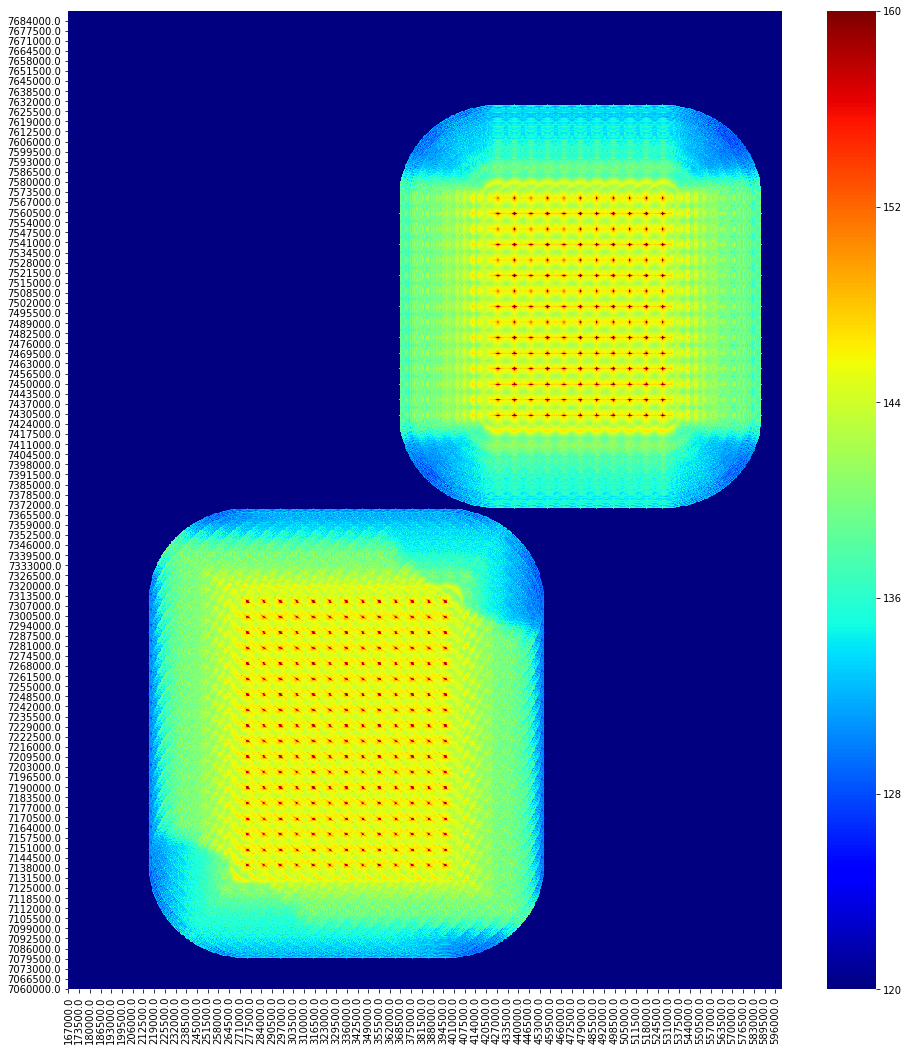

In [47]:
plt.figure(figsize=(16,18))
#plt.title(plottitle)
ax = sns.heatmap(max_plot_all, cmap='jet', vmin=120, vmax=160)
ax.invert_yaxis();

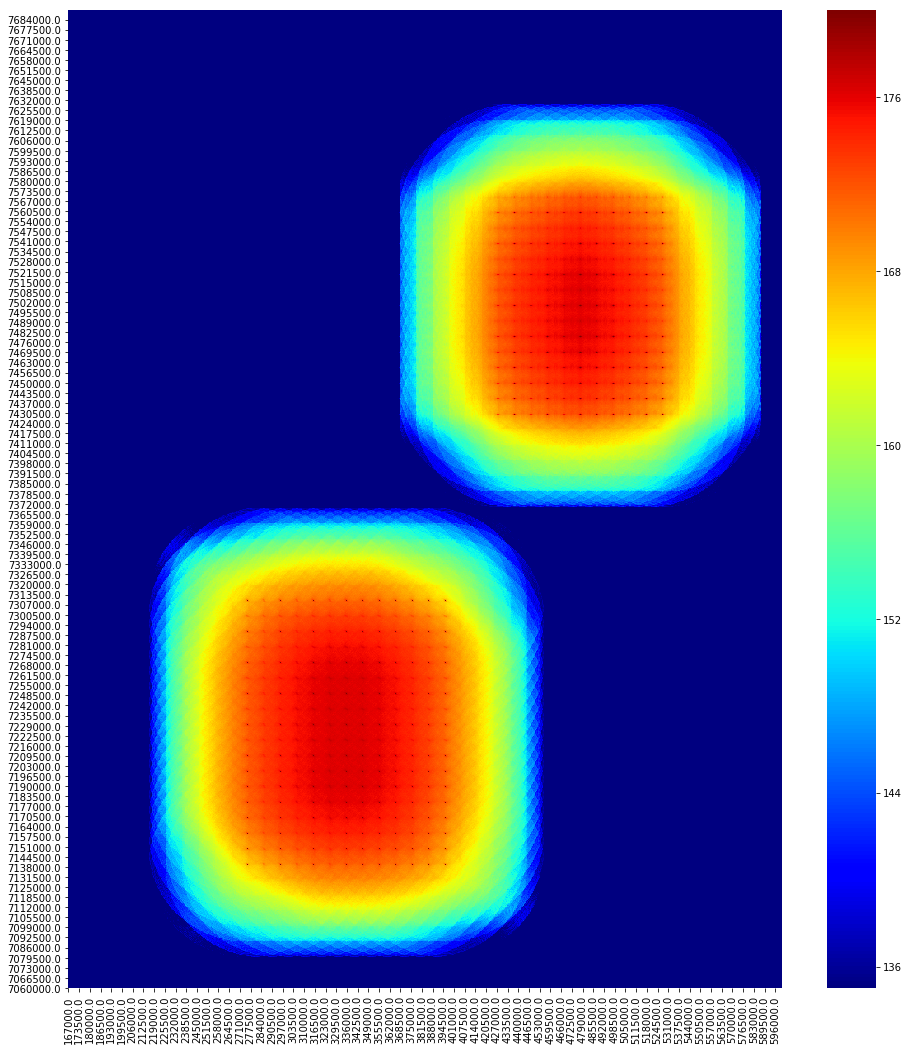

In [48]:
plt.figure(figsize=(16,18))
#plt.title(plottitle)
ax = sns.heatmap(sum_plot_all, cmap='jet', vmin=135, vmax=180)
ax.invert_yaxis();

## Stop

In [49]:
magnus

NameError: name 'magnus' is not defined

In [ ]:
def inc_stack(data1, n):
    data1_temp = data1.copy(deep=True)
    for i in range(1,n+1):
        if i >= data1_temp.shape[1]:
            data1_temp[i] = data1_temp.min(axis=1)
        data1_temp[i] = dB_sum(data1_temp[i-1], data1_temp[i])
    return data1_temp

In [ ]:
shot1_cartesian.shape[0]

In [ ]:
shot1_cartesian.min().min()

In [ ]:
shot_acum = inc_stack(shot1_cartesian, 1201)

In [ ]:
shot_acum.max().max()

In [ ]:
plt.figure(figsize=(16,12))
#plt.title(plottitle)
sns.heatmap(shot1_cartesian, cmap='jet', vmin=minval, vmax=maxval);

In [ ]:
plt.figure(figsize=(16,6))
#plt.title(plottitle)
sns.heatmap(shot_acum, cmap='jet', vmin=minval, vmax=maxval);

In [ ]:
def apply_scaling(data2, scale):
    data2_scaled = data2 + 10*np.log10(scale)
    return data2_scaled

In [ ]:
shot_acum_scaled = apply_scaling(shot_acum, 5.3333)

In [ ]:
shot_acum_scaled.max().max()

In [ ]:
plt.figure(figsize=(16,6))
#plt.title(plottitle)
sns.heatmap(shot_acum_scaled, cmap='jet', vmin=minval, vmax=maxval);

In [ ]:
df_singleshot_y_600 = shot_cartesian.loc[600]
df_singleshot_y_605 = shot_cartesian.loc[605]
df_singleshot_y_700 = shot_cartesian.loc[700]

In [ ]:
df_shot_acu_y_600 = shot_acum.loc[600]
df_shot_acu_y_605 = shot_acum.loc[605]
df_shot_acu_y_700 = shot_acum.loc[700]

In [ ]:
df_shot_acu_scaled_y_600 = shot_acum_scaled.loc[600]
df_shot_acu_scaled_y_605 = shot_acum_scaled.loc[605]
df_shot_acu_scaled_y_700 = shot_acum_scaled.loc[700]

In [ ]:
#df_y_600

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df_singleshot_y_600)
plt.plot(df_shot_acu_y_600)
plt.plot(df_shot_acu_scaled_y_600)
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df_singleshot_y_605)
plt.plot(df_shot_acu_y_605)
plt.plot(df_shot_acu_scaled_y_605)
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df_singleshot_y_700)
plt.plot(df_shot_acu_y_700)
plt.plot(df_shot_acu_scaled_y_700)
plt.show()

In [ ]:
A = np.random.randn(4,3)
B = np.sum(A, axis = 1, keepdims = True)

In [ ]:
A

In [ ]:
B.shape